# BBC news clasification

## Matrix factorization

### Project of the course Unsupervised Algorithms in Machine Learning

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from itertools import permutations
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import time

In [3]:
train = pd.read_csv("../Data/BBC News Train.csv")
test = pd.read_csv("../Data/BBC News Test.csv")

### Constants

In [4]:
N_NEIGH_LIST = list(range(2, 20)) + [
    22,
    25,
    27,
    30,
    35,
    40,
    50,
    75,
    100,
    150,
    200,
]

#### EDA

In [5]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<AxesSubplot:xlabel='Category', ylabel='Count'>

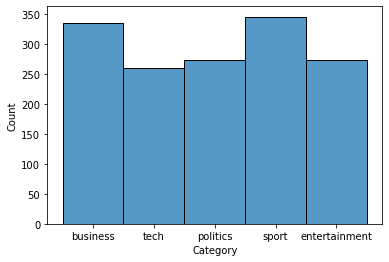

In [6]:
sns.histplot(train["Category"])

Delete punctuation signs and transform into lowercase

In [7]:
train["Text"] = train["Text"].apply(
    lambda x: "".join([s.lower() for s in x if s not in string.punctuation])
)
test["Text"] = test["Text"].apply(
    lambda x: "".join([s for s in x if s not in string.punctuation])
)

Tockenization

In [8]:
train["Text"] = train["Text"].apply(lambda x: x.split(" "))
test["Text"] = test["Text"].apply(lambda x: x.split(" "))

Delete stopwords

In [12]:
#nltk.download('stopwords')

In [13]:
stopwords = nltk.corpus.stopwords.words("english")

In [14]:
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]

In [15]:
train["Text"] = train["Text"].apply(lambda t: [w for w in t if w not in stopwords])
test["Text"] = test["Text"].apply(lambda t: [w for w in t if w not in stopwords])

Lenght of text attribute

In [16]:
train["length"] = train["Text"].apply(len)

In [17]:
test["length"] = test["Text"].apply(len)

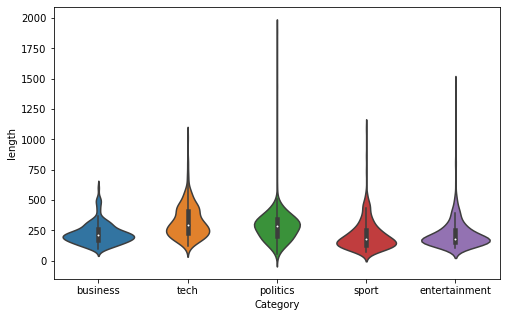

In [18]:
sns.violinplot(data=train, y="length", x="Category")
fig = plt.gcf()
fig.set_size_inches(8, 5)

In [19]:
train

,ArticleId,Text,Category,length
0,1833,"[worldcom, exboss, launches, defence, lawyers,...",business,215
1,154,"[german, business, confidence, slides, german,...",business,227
2,1101,"[bbc, poll, indicates, economic, gloom, citize...",business,330
3,1976,"[lifestyle, , governs, mobile, choice, , faste...",tech,413
4,917,"[enron, bosses, 168m, payout, eighteen, former...",business,239
...,...,...,...,...
1485,857,"[double, eviction, big, brother, model, capric...",entertainment,139
1486,325,"[dj, double, act, revamp, chart, show, dj, duo...",entertainment,377
1487,1590,"[weak, dollar, hits, reuters, revenues, media,...",business,165
1488,1587,"[apple, ipod, family, expands, market, apple, ...",tech,365


In [20]:
classes = train["Category"].unique()

### Data preprocessing

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    train.drop("Category", axis=1), train["Category"], test_size=0.25
)

In [22]:
vectorizer = TfidfVectorizer()

In [23]:
x_train_vectorized = np.array(
    vectorizer.fit_transform(x_train["Text"].apply(lambda x: " ".join(x))).todense()
)

In [24]:
x_test_vectorized = np.array(
    vectorizer.transform(x_test["Text"].apply(lambda x: " ".join(x))).todense()
)


In [25]:
x_test_kaggle = np.array(
    vectorizer.transform(test["Text"].apply(lambda x: " ".join(x))).todense()
)


### Baseline model

In [26]:
knn = KNeighborsClassifier()

In [27]:
knn_gridcv = GridSearchCV(knn, param_grid={"n_neighbors": N_NEIGH_LIST},)

Cross validation

In [28]:
knn_gridcv.fit(x_train_vectorized, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 22, 25, 27, 30,
                                         35, 40, 50, 75, 100, 150, 200]})

In [29]:
knn = knn_gridcv.best_estimator_
knn_gridcv.best_estimator_

KNeighborsClassifier(n_neighbors=16)

In [30]:
knn_gridcv.best_score_

0.9507607303010891

Test metrics

In [31]:
y_test_pred = knn.predict(x_test_vectorized)

In [32]:
y_test_pred_proba = knn.predict_proba(x_test_vectorized)

In [33]:
accuracy_score(y_test, y_test_pred)

0.9410187667560321

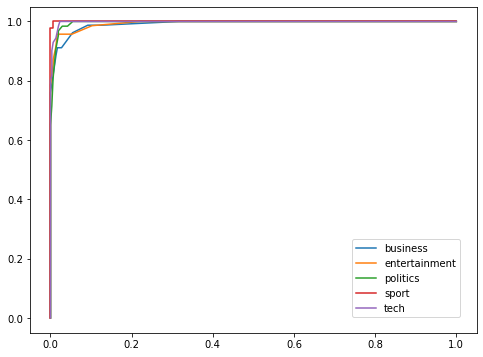

In [34]:
fig, ax = plt.subplots()
for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(
        (y_test == knn.classes_[i]).astype(int), y_test_pred_proba[:, i]
    )
    ax.plot(fpr, tpr)
fig.legend(labels=knn.classes_, loc=4, bbox_to_anchor=(0.88, 0.15))
fig.set_size_inches(8, 6)

### Non negative matrix factorization

#### Dimensionality reduction

In [35]:
sklearn_svd = TruncatedSVD(n_components=2)

In [36]:
x_train_2d = sklearn_svd.fit_transform(x_train_vectorized)

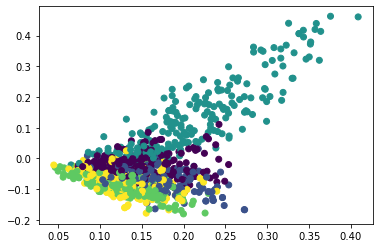

In [37]:
fig, ax = plt.subplots()
ax.scatter(
    x_train_2d[:, 0],
    x_train_2d[:, 1],
    c=y_train.apply(lambda x: list(classes).index(x)),
)

#### Unsupervised approach for the classification problem

In [38]:
sklearn_svd = TruncatedSVD(n_components=5)

In [39]:
pred_train_svd = np.argmax(sklearn_svd.fit_transform(x_train_vectorized), axis=1)

In [40]:
pred_test_svd = np.argmax(sklearn_svd.transform(x_test_vectorized), axis=1)

Finds best permutation for labels

In [41]:
perm_final = None
acc_final = 0
for p in permutations(classes):
    pred_train_svd_label = [p[i] for i in pred_train_svd]
    acc_score = accuracy_score(y_train.values, pred_train_svd_label)
    if acc_score > acc_final:
        perm_final = p
        acc_final = acc_score

In [42]:
perm_final

('tech', 'politics', 'sport', 'entertainment', 'business')

Final metrics over train and test set

In [43]:
acc_final

0.41897940913160253

In [44]:
pred_test_svd_label = [perm_final[i] for i in pred_test_svd]
accuracy_score(y_test.values, pred_test_svd_label)

0.40214477211796246

#### Dimensionality reduction as preprocessing

In [45]:
res_table = pd.DataFrame(columns=["k", "score", "time_train"])

In [46]:
knn_mf = KNeighborsClassifier()
max_acc = 0
knn_best = None
svd_best = None
for n_comp in list(range(2, 25)) + [27, 30, 35, 40, 50, 75, 100, 150, 200, 300]:
    t0 = time.time_ns()
    sklearn_svd = TruncatedSVD(n_components=n_comp)
    x_train_vectorized_mf = sklearn_svd.fit_transform(x_train_vectorized)
    knn_gridcv = GridSearchCV(knn_mf, param_grid={"n_neighbors": N_NEIGH_LIST},)
    knn_gridcv.fit(x_train_vectorized_mf, y_train)
    score = knn_gridcv.best_score_
    t1 = time.time_ns()
    res_table.loc[n_comp] = [
        knn_gridcv.best_estimator_.n_neighbors,
        score,
        (t1 - t0) / 1000000,
    ]
    if score > max_acc:
        max_acc = score
        knn_best = knn_gridcv.best_estimator_
        svd_best = sklearn_svd

In [47]:
res_table

,k,score,time_train
2,40.0,0.567609,1070.429
3,22.0,0.802134,1128.338
4,18.0,0.879120,1155.019
5,9.0,0.946268,1186.038
6,3.0,0.942689,1263.985
7,7.0,0.948062,1382.580
8,5.0,0.949856,1324.144
9,10.0,0.949864,1340.949
10,5.0,0.951666,1348.093
11,5.0,0.954340,1416.537


Best model

In [48]:
x_train_vectorized_mf = svd_best.fit_transform(x_train_vectorized)
x_test_vectorized_mf = svd_best.transform(x_test_vectorized)

In [49]:
knn_best.fit(x_train_vectorized_mf, y_train)

KNeighborsClassifier(n_neighbors=6)

In [50]:
y_test_pred = knn_best.predict(x_test_vectorized_mf)

In [51]:
accuracy_score(y_test, y_test_pred)

0.9544235924932976

### Model refinement

Inclusion of lenght attribute

In [52]:
x_train_vectorized_len = np.c_[x_train_vectorized, x_train["length"].values]
x_test_vectorized_len = np.c_[x_test_vectorized, x_test["length"].values]

In [53]:
knn_len = KNeighborsClassifier()

In [54]:
knn_gridcv = GridSearchCV(knn_len, param_grid={"n_neighbors": N_NEIGH_LIST},)

In [55]:
max_acc = 0
sc_best = None
knn_len_best = None
for i in range(15):
    sc = 2 ** (-i)
    x_train_vectorized_len_iter = x_train_vectorized_len.copy()
    x_train_vectorized_len_iter[:, -1] = x_train_vectorized_len_iter[:, -1] * sc
    knn_gridcv.fit(x_train_vectorized_len_iter, y_train)
    score = knn_gridcv.best_score_
    if score > max_acc:
        max_acc = score
        knn_best = knn_gridcv.best_estimator_
        sc_best = sc

In [56]:
x_test_vectorized_len_iter = x_test_vectorized_len.copy()
x_test_vectorized_len_iter[:, -1] = x_test_vectorized_len_iter[:, -1] * sc

In [57]:
max_acc

0.9543401665598974

In [58]:
y_test_pred = knn_best.predict(x_test_vectorized_len_iter)

In [59]:
accuracy_score(y_test, y_test_pred)

0.935656836461126

### Result submision